In [1]:
# Importing all the necessary libraries
from tensorflow.keras.datasets import mnist
import torchvision
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import numpy as np
import torch
from torch import nn
from collections import defaultdict
from functools import partial
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import copy

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 28, 28)
(60000,)
(10000,)


In [4]:
# What is being done here:
# We are collecting all the images by classes
# Each entry in the 'output' list is 
# a numpy array of all the images by class
output = []
for i in range(10):
    classno = X_train[np.where(y_train==i)]
    output.append(classno)

In [5]:
# What is happening here:
# We are stacking the classes into one output 'total_list'
# In addition, we are also appending the cluster center into each class
# This is needed for the next step: T-Stochastic Nearest Neighbors plotting

total_list = []
indices = []
for number in range(10):
    kmeans = KMedoids(n_clusters = 256)
    kmeans.fit(output[number])
    output[number] = kmeans.cluster_centers_
    total_list.append(output[number][:])
    if not indices:
        indices.append(output[number].shape[0])
    else:         
        indices.append(indices[-1] + output[number].shape[0])
        
total_list = np.concatenate(total_list, axis=0)

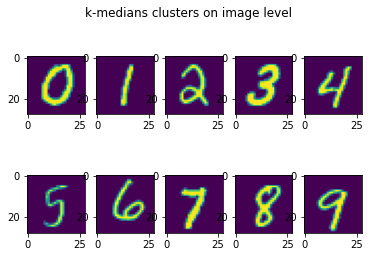

In [6]:
# Printing all the k-means cluster (0-9)
fig, axs = plt.subplots(2,5)
fig.suptitle('k-medians clusters on image level')
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(total_list[indices[5*i + j]-1].reshape(28,28))

In [7]:
# We do the TSNE transform on total_list
from sklearn.manifold import TSNE
tsne_points = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(total_list)

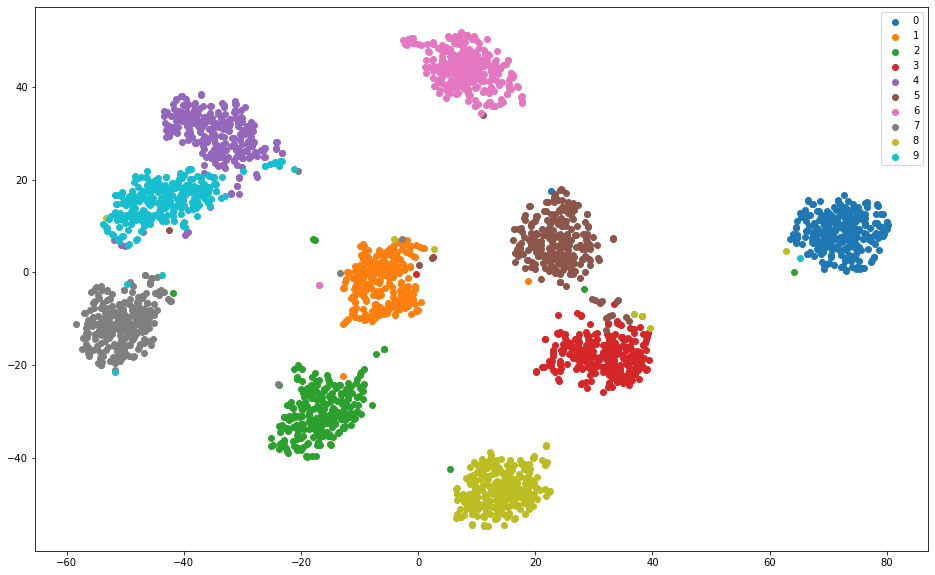

In [16]:
# Doing a naive plotting here.
# What needs to be done:
# 1. Change the color for each cluster - Done
# 2. Differentiate the color of the cluster from its centroid - Undone
# 3. Have a legend print out all the cluster with its label - Done

# What if we use only the k-means from the clusters ?
start = 0
plt.figure(figsize=(16,10))
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuBuGn']

for i,end in enumerate(indices):
    plt.scatter(tsne_points[start:end,0], tsne_points[start:end,1], cmap=cmaps[i], label=i)
    plt.legend()
    start = end
    
plt.savefig('mnist-k-medioids-clustermaps.png')

In [10]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

/Users/aditya-the-great/miniconda3/envs/torch-dev/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch 0 - Training loss: 0.3812303795798946
Epoch 1 - Training loss: 0.18145775382738633
Epoch 2 - Training loss: 0.13066494065934597
Epoch 3 - Training loss: 0.10636367021339026
Epoch 4 - Training loss: 0.09150411213027325
Epoch 5 - Training loss: 0.08063878455876446
Epoch 6 - Training loss: 0.06999137446354789
Epoch 7 - Training loss: 0.064808540686127
Epoch 8 - Training loss: 0.05800215376646264
Epoch 9 - Training loss: 0.05236963927398311
Epoch 10 - Training loss: 0.04716445676270507
Epoch 11 - Training loss: 0.045114894116912704
Epoch 12 - Training loss: 0.04122340845473201
Epoch 13 - Training loss: 0.037892021191874715
Epoch 14 - Training loss: 0.03289089702807718

Training Time (in minutes) = 1.9889286677042644
Predicted Digit = 3
Number Of Images Tested = 10000

Model Accuracy = 0.9728


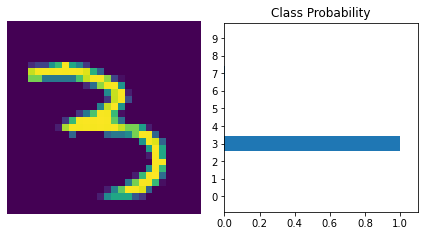

In [11]:
# Now let's start training the network

import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
valset = datasets.MNIST('./', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

optimizer = optim.Adam(model.parameters(), lr=0.001)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))



In [12]:
classlabellist = defaultdict(list)
with torch.no_grad():
    for images, labels in trainloader:

        images = images.view(images.shape[0], -1)

        output = model(images)
        
        for i in range(10):
            classno = output[np.where(labels==i)[0]].numpy()
            classlabellist[i].extend(classno)
            
            
returnlist = []
for label in classlabellist:
    returnlist.append(np.array(classlabellist[label]))

In [13]:
label_list = []
indices = []
for number in range(10):
    kmeans = KMedoids(n_clusters = 256)
    kmeans.fit(returnlist[number])
    returnlist[number] = kmeans.cluster_centers_
    label_list.append(returnlist[number][:])
    if not indices:
        indices.append(returnlist[number].shape[0])
    else:         
        indices.append(indices[-1] + returnlist[number].shape[0])
        
label_list = np.concatenate(label_list, axis=0)

In [14]:
# We do the TSNE transform on total_list
from sklearn.manifold import TSNE
label_points = TSNE(n_components=2, perplexity = 50, n_iter = 1000).fit_transform(label_list)

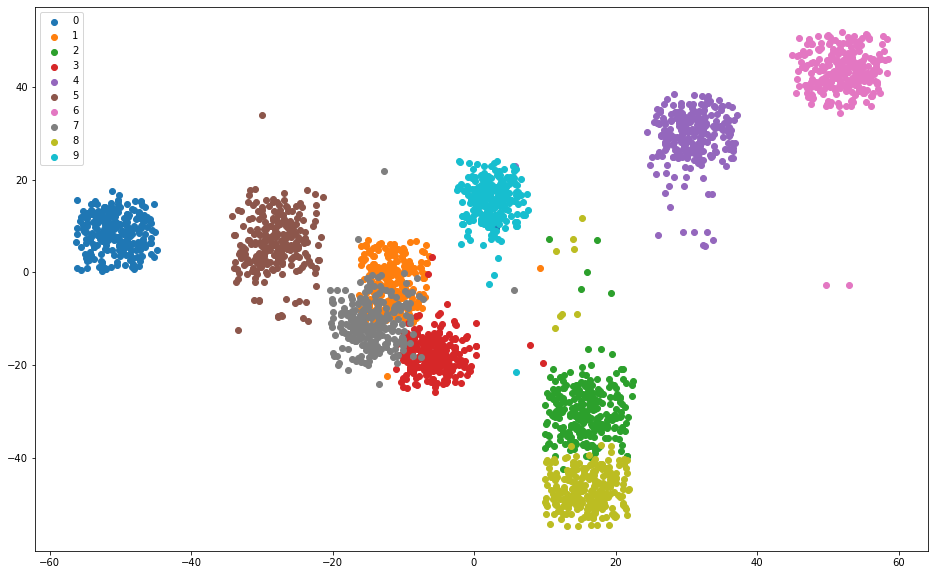

In [15]:
# Doing a naive plotting here.
# What needs to be done:
# 1. Change the color for each cluster - Done
# 2. Differentiate the color of the cluster from its centroid - Undone
# 3. Have a legend print out all the cluster with its label - Done
start = 0
plt.figure(figsize=(16,10))
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuBuGn']

for i,end in enumerate(indices):
    plt.scatter(label_points[start:end,0], tsne_points[start:end,1], cmap=cmaps[i], label=i)
    plt.legend()
    start = end
    
plt.savefig('labels_clustering.png')